# Simple Scalping Strategy

It is a simple scalping strategy with a few parameters:

* Only use close parameter of candles -> No intra "interval" trading
* Use EMA "Slow" & "Fast" to determine the trend
* Use bollinger 15m to determine the entry point
* When uptrend and price is below lower bollinger -> **buy**
* When downtrend and price is above upper bollinger -> **sell**

https://coindcx.com/blog/cryptocurrency/10-best-indicators-for-crypto-trading

In [1]:
import retrieval.cache as cache
import signals.curve as curve
import signals.simple_scalping as simple_scalping

import numpy as np
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from backtesting import Backtest, Strategy
from matplotlib import pyplot as plt
from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/pytrading/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Overarching Constants

In [3]:
ticker = 'BTC-USD'
start = '2022-01-01'
end = '2023-01-01'
interval = '1h'
ema_slow_len = 50
ema_fast_len = 30
rsi_len=10
bbands_period_len=15 # How many periods to use for the average (usually a EMA close is used)
bbands_std=1.5 # Subtract this many standard deviations from the average to get the lower band. (Add to get the upper band)

columns_open = 'Open'
columns_high = 'High'
columns_low = 'Low'
columns_close = 'Close'
columns_volume = 'Volume'
columns_rsi = 'RSI'
columns_ema_slow = 'EMA_Slow'
columns_ema_fast = 'EMA_Fast'
columns_atr = 'ATR'
column_signal_ema = 'EMA_Signal'
columns_simple_scalp = 'Simple_Scalp'
columns_bollinger_low = f'BBL_{bbands_period_len}_{bbands_std}'
columns_bollinger_mid = f'BBM_{bbands_period_len}_{bbands_std}'
columns_bollinger_high = f'BBU_{bbands_period_len}_{bbands_std}'

refresh_cache=True
back_candle_length = 7

### Make sure we have some data to work with

In [4]:
if not cache.exist_sql_db(ticker, interval) or refresh_cache:
    # load data from yahoo finance and cache it in sql db
    cache.cache_ticker(ticker, interval, start, end)

# Load data from sql db
df = cache.load_ticker(ticker, interval, start, end, index_column='Date')

#df

NameError: name 'cache' is not defined

### Add TA Columns

In [4]:
df[columns_ema_slow] = ta.ema(df[columns_close], length=ema_slow_len)
df[columns_ema_fast] = ta.ema(df[columns_close], length=ema_fast_len)
df[columns_rsi] = ta.rsi(df[columns_close], length=rsi_len)

# Average True Range (or Volatility) - help to define stop loss / take profit distance
df[columns_atr] = ta.atr(df[columns_high], df[columns_low], df[columns_close], length=back_candle_length)

# Bollinger bands
if columns_bollinger_low not in df.columns:
  df=df.join(ta.bbands(df[columns_close], length=bbands_period_len, std=bbands_std))

#df

### Plot

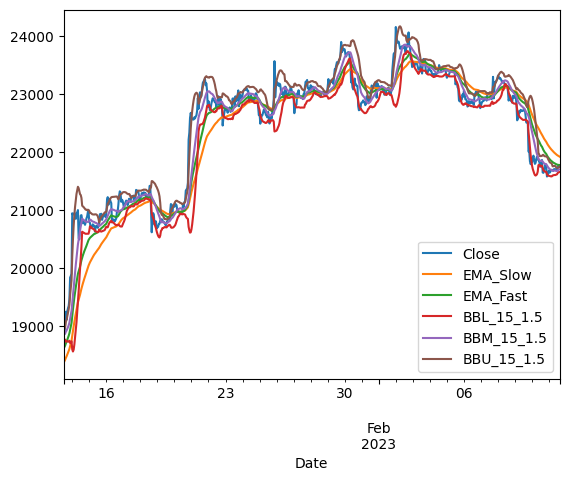

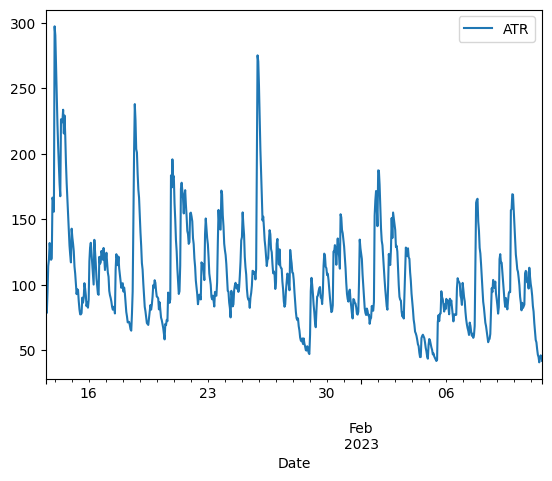

In [5]:
df[300:1000].plot(
  y=[
    columns_close, 
    columns_ema_slow, 
    columns_ema_fast, 
    columns_bollinger_low, 
    columns_bollinger_mid, 
    columns_bollinger_high
  ])

plt.show()

df[300:1000].plot(y=[columns_atr])
plt.show()

### EMA signal function

In [6]:
# Needed for progress_apply
tqdm.pandas()

df.reset_index(inplace=True)

# At current candle: Check if all EMA_Fast values are:
# Below EMA_Slow = 2  => Sell
# Above EMA_Slow = 1 => Buy
df[column_signal_ema] = df.progress_apply(
  lambda row: curve.above_or_below_curve(
    df, row.name, back_candle_length,
    curve=columns_ema_fast,
    compare=columns_ema_slow,
    ), 
  axis=1
)

#df

  0%|          | 0/8676 [00:00<?, ?it/s]

100%|██████████| 8676/8676 [00:03<00:00, 2778.81it/s]


### Plot

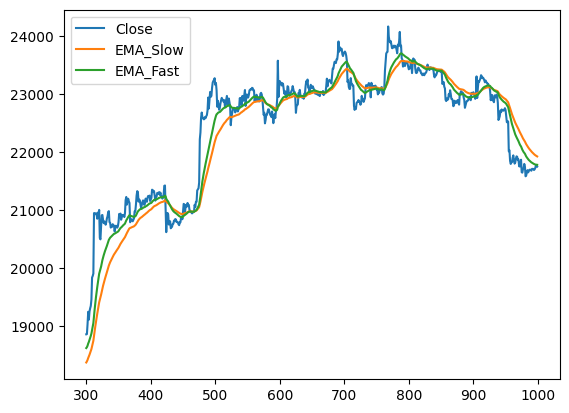

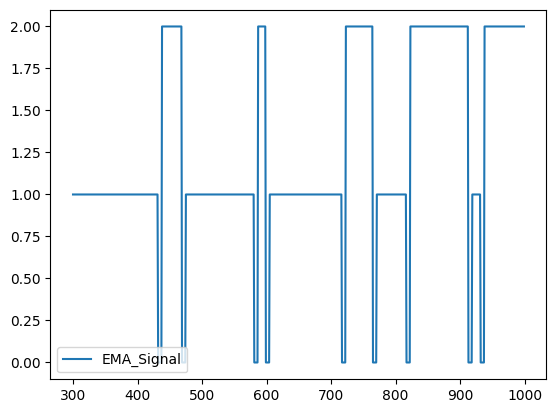

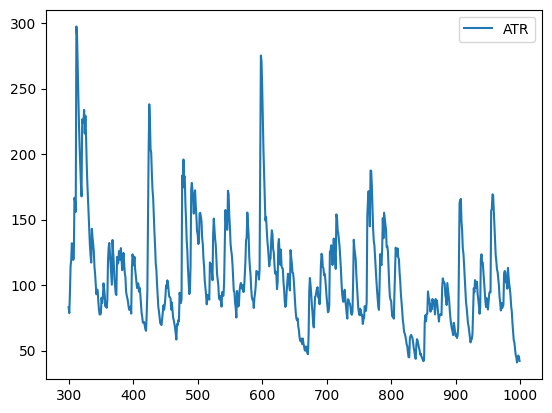

In [7]:
df[300:1000].plot(y=[columns_close, columns_ema_slow, columns_ema_fast])
plt.show()

df[300:1000].plot(y=[column_signal_ema])
plt.show()

df[300:1000].plot(y=[columns_atr])
plt.show()

### Calculate the Simple Scalping Signal

In [8]:
df[columns_simple_scalp] = df.progress_apply(
  lambda row: simple_scalping.simple_signal(
    df, row.name, 
    back_candle_length,
    ema_fast=columns_ema_fast,
    ema_slow=columns_ema_slow,
    bollinger_low=columns_bollinger_low,
    bollinger_high=columns_bollinger_high,    
    ), axis=1
)

df[df[columns_simple_scalp] != 0].head(40)

100%|██████████| 8676/8676 [00:06<00:00, 1264.23it/s]


,Date,Open,High,Low,Close,Adj Close,Volume,EMA_Slow,EMA_Fast,RSI,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5,EMA_Signal,Simple_Scalp
63,2023-01-03 15:00:00,16687.105469,16687.105469,16639.509766,16665.871094,16665.871094,548231168,16669.361155,16701.594501,36.113643,32.757130,16674.825710,16713.648438,16752.471165,0.464563,-0.115327,1,2
64,2023-01-03 16:00:00,16667.441406,16685.496094,16630.984375,16630.984375,16630.984375,389563392,16667.856183,16697.039009,29.810144,35.865090,16662.329503,16710.504688,16758.679872,0.576586,-0.325324,1,2
65,2023-01-03 17:00:00,16629.419922,16641.076172,16622.371094,16630.164062,16630.164062,271706112,16666.378061,16692.724496,29.674820,33.413551,16650.729615,16706.905469,16763.081323,0.672487,-0.183046,1,2
92,2023-01-04 20:00:00,16840.978516,16847.107422,16802.753906,16804.451172,16804.451172,293746688,16766.288644,16806.371475,45.001251,54.988669,16804.887030,16857.401302,16909.915574,0.623041,-0.004150,1,2
105,2023-01-05 09:00:00,16814.126953,16816.832031,16798.621094,16804.048828,16804.048828,0,16793.855829,16821.933691,40.589764,27.623923,16809.736571,16834.067448,16858.398325,0.289067,-0.116883,1,2
109,2023-01-05 13:00:00,16831.501953,16831.501953,16799.576172,16801.863281,16801.863281,276144128,16798.748156,16823.014460,40.964854,26.979228,16809.271865,16833.832682,16858.393500,0.291803,-0.150821,1,2
124,2023-01-06 04:00:00,16836.921875,16838.599609,16809.076172,16823.570312,16823.570312,125524992,16818.564278,16835.162157,43.694305,24.567097,16825.061391,16843.200781,16861.340171,0.215391,-0.041101,1,2
125,2023-01-06 05:00:00,16824.316406,16824.316406,16807.644531,16814.693359,16814.693359,102779904,16818.412477,16833.841589,40.756459,23.439208,16820.869049,16841.799870,16862.730690,0.248558,-0.147526,1,2
126,2023-01-06 06:00:00,16814.363281,16815.222656,16792.867188,16792.867188,16792.867188,55029760,16817.410701,16831.198079,34.431826,23.284388,16810.577729,16837.693359,16864.808990,0.322082,-0.326574,1,2
127,2023-01-06 07:00:00,16793.988281,16801.128906,16786.556641,16798.263672,16798.263672,0,16816.659837,16829.073279,37.112797,22.039799,16804.077365,16834.898828,16865.720291,0.366162,-0.094312,1,2


### Set back to datetime index (from range index)

In [9]:
df.set_index('Date', inplace=True)

### Create Dots for Simple Scalping Signals

In [10]:
def render_short_long_signal_point(row: pd.Series, column_name:str) -> str:
  if row[column_name] == simple_scalping.LONG_SIGNAL:
    return row[columns_low]-1e-3
  elif row[column_name] == simple_scalping.SHORT_SIGNAL:
    return row[columns_high]+1e-3
  
  return np.nan

df['ss_point'] = df.apply(lambda row: render_short_long_signal_point(row, columns_simple_scalp), axis=1)

### Plot the Graph

In [11]:
partition = df[300:1000].copy()

import plotly.graph_objects as go
from plotly.subplots import make_subplots

partition = df[300:1000].copy()  # Copy pandas DataFrame

# Create a subplot with 2 rows and 1 column, and specify the height of each row
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, 
                    subplot_titles=('Market Data', 'RSI'), 
                    row_heights=[0.7, 0.3])

# Candlestick plot
fig.add_trace(go.Candlestick(x=partition.index,
                             open=partition[columns_open],
                             high=partition[columns_high],
                             low=partition[columns_low],
                             close=partition[columns_close]), 
              row=1, col=1)

# Bollinger Bands plots
fig.add_trace(go.Scatter(x=partition.index, y=partition[columns_bollinger_low], 
                         line=dict(color='blue', width=1), 
                         name='BBL'), 
              row=1, col=1)

fig.add_trace(go.Scatter(x=partition.index, y=partition[columns_bollinger_high],
                         line=dict(color='blue', width=1),
                         name='BBU'), 
              row=1, col=1)

# EMA plots
fig.add_trace(go.Scatter(x=partition.index, y=partition[columns_ema_slow],
                         line=dict(color='orange', width=1),
                         name='EMA Slow'), 
              row=1, col=1)

fig.add_trace(go.Scatter(x=partition.index, y=partition[columns_ema_fast],
                         line=dict(color='green', width=1),
                         name='EMA Fast'), 
              row=1, col=1)

# Simple Scalp plot
fig.add_trace(go.Scatter(x=partition.index, y=partition['ss_point'],
                         mode='markers', marker=dict(color='darkorange', size=5),
                         name=columns_simple_scalp), 
              row=1, col=1)

# RSI plot
fig.add_trace(go.Scatter(x=partition.index, y=partition[columns_rsi],
                         line=dict(color='red', width=1),
                         name='RSI'), 
              row=2, col=1)

# Update layout if necessary
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True,
            thickness=0.05  # Adjust the thickness of the range slider
        ),
        type="date"
    ),
    xaxis2=dict(
        rangeslider=dict(
            visible=False
        ),
    ),
    height=800, title_text="Market Data with RSI"
)

# Show the figure
fig.show()

### Backtesting

In [12]:
def signal():
    return df[columns_simple_scalp]

class MyStrategy(Strategy):
    # Stop loss coefficient
    sl_coef = 1.1
    tpsl_ratio = 1.5

    def init(self):
        super().init()

        self.simple_scalp_signal = self.I(signal)

    def next(self):
        super().next()

        # Stop-loss distance
        sl_atr = self.sl_coef * self.data.ATR[-1]
        tpsl_ratio = self.tpsl_ratio

        
        if self.simple_scalp_signal == simple_scalping.LONG_SIGNAL and len(self.trades) == 0:
            sl1 = self.data[columns_close][-1] - sl_atr
            tp1 = self.data[columns_close][-1] + sl_atr * tpsl_ratio
            self.buy(sl=sl1, tp=tp1)

        if self.simple_scalp_signal == simple_scalping.SHORT_SIGNAL and len(self.trades) == 0:
            sl1 = self.data[columns_close][-1] + sl_atr
            tp1 = self.data[columns_close][-1] - sl_atr * tpsl_ratio
            self.sell(sl=sl1, tp=tp1)

bt = Backtest(df, MyStrategy, cash=100000)

bt.run()

Start                     2023-01-01 00:00:00
End                       2023-12-31 23:00:00
Duration                    364 days 23:00:00
Exposure Time [%]                   35.707699
Equity Final [$]                146552.947625
Equity Peak [$]                 147510.038653
Return [%]                          46.552948
Buy & Hold Return [%]              155.481638
Return (Ann.) [%]                   46.706916
Volatility (Ann.) [%]               21.059503
Sharpe Ratio                         2.217855
Sortino Ratio                        4.844996
Calmar Ratio                         6.066537
Max. Drawdown [%]                   -7.699106
Avg. Drawdown [%]                   -0.844229
Max. Drawdown Duration       80 days 21:00:00
Avg. Drawdown Duration        3 days 14:00:00
# Trades                                  491
Win Rate [%]                        45.417515
Best Trade [%]                       3.047278
Worst Trade [%]                     -1.735033
Avg. Trade [%]                    

### Plot the Backtesting Results

In [13]:
bt.plot()

/opt/homebrew/Caskroom/miniforge/base/envs/pytrading/lib/python3.12/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/opt/homebrew/Caskroom/miniforge/base/envs/pytrading/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

/opt/homebrew/Caskroom/miniforge/base/envs/pytrading/lib/python3.12/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/opt/homebrew/Caskroom/miniforge/base/envs/pytrading/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

/opt/homebrew/

GridPlot(id='p1350', ...)